In [1]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
import cftime

### Function Definition

In [2]:
'''
This function opens the file and put them in a list (the file pattern given) 
of a list (every query of that file pattern).

file_pattern must be a list.
exclude_files (optional): include the name of the file you would like to exclude

example:

file_pattern = ['tas_Amon_CanESM5_piControl_r1i1p1f1_gn_*.nc', 
                'rlut_Amon_CanESM5_piControl_r1i1p1f1_gn_*.nc']
would open all of these files and output a list like this:
output (ddict) = ['tas_xxx.nc, rlut_xxx.nc']
'''
def Open_Files(file_pattern, exclude_files="None"):
    ddict = []
    for order in range(len(file_pattern)):
        ds = []
        all_files = glob.glob(file_pattern[order])
        if exclude_files != "None":
            file_paths = [f for f in all_files if exclude_files not in f]
        else:
            file_paths = all_files
        if len(file_paths) == 1:
            ds = xr.open_dataset(file_paths[0])
        elif len(file_paths) == 0:
            raise ValueError("Could not locate the file. Check the directory path.")
        else:
            ds = xr.open_mfdataset(file_paths, combine='by_coords', use_cftime=True)
        ddict.append(ds)
    return ddict

In [3]:
# Make a file name based on variable, model, experiment, year range, variant, and grid. 
# Use * to find all of them
def NewFile(var, model, exp, number="*", variant="r1i1p1f1", grid="*"):
    newname = []
    newname.append(f"{var}_Amon_{model}_{exp}_{variant}_{grid}_{number}.nc")
    #naming convention: Variable_realm_model_experiment_variant_grid_startyyyymm-endyyyymm.nc
    #example: hfls_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-620012.nc
    return newname[0]

#make a new file name, but with the correct directory leading to the file
def LocateFile(path, file_name, model, exp, variant):
    newpath = (f"{path}/{model}/{exp}/{variant}/{file_name}")
    return newpath

''' 
Read the data from the file

The format of the file must be lists like this
[abe, 123]
[bce, 394, hello, 34857d]
...

The output will be like this:
[[abe, 123], [bce, 394, hello, 34857d], ...]
'''
def ReadFile(filename):
  nested_list = []
  with open(filename, 'r') as f:
    for line in f:
      cleanline = line.strip('[]\n')
      sublist = [item.strip() for item in cleanline.split(',')]
      nested_list.append(sublist)
  return nested_list

### Analysis

/data/keeling/a/kchoo3/anaconda3/envs/myenv/lib/python3.12/site-packages/xarray/coding/times.py:995: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/data/keeling/a/kchoo3/anaconda3/envs/myenv/lib/python3.12/site-packages/xarray/core/indexing.py:630: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/data/keeling/a/kchoo3/anaconda3/envs/myenv/lib/python3.12/site-packages/xarray/core/indexing.py:500: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/data/keeling/a/kchoo3/anaconda3/envs/myenv/

<Figure size 5600x2000 with 0 Axes>

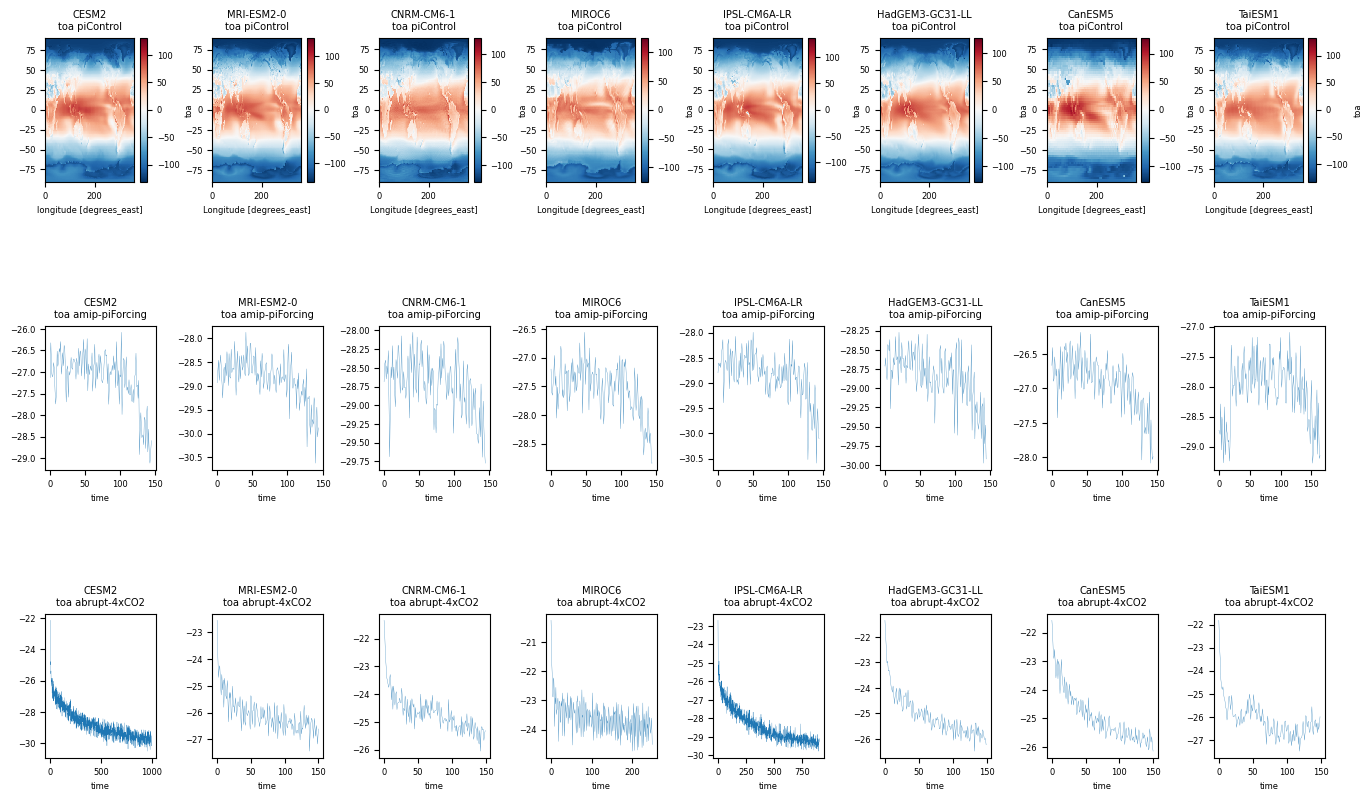

<Figure size 5600x2000 with 0 Axes>

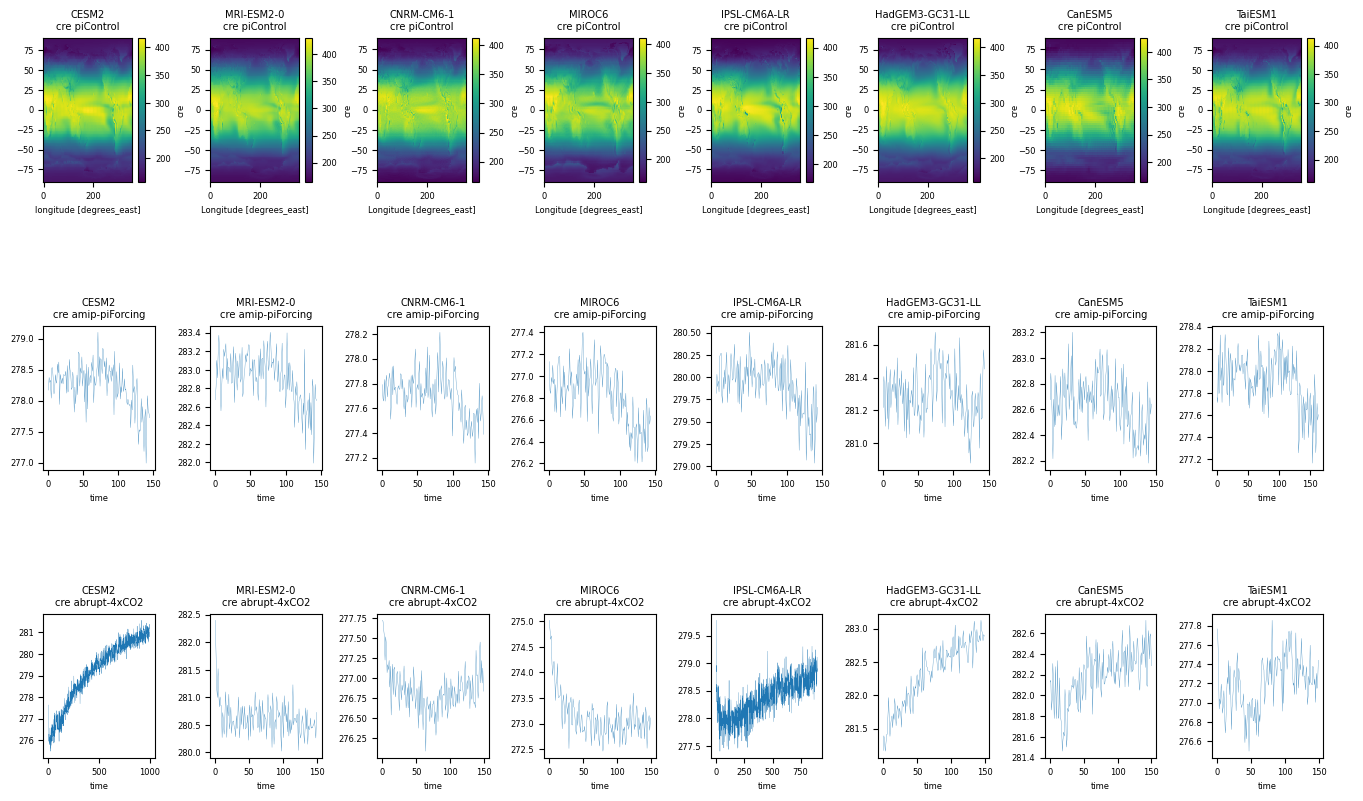

<Figure size 5600x2000 with 0 Axes>

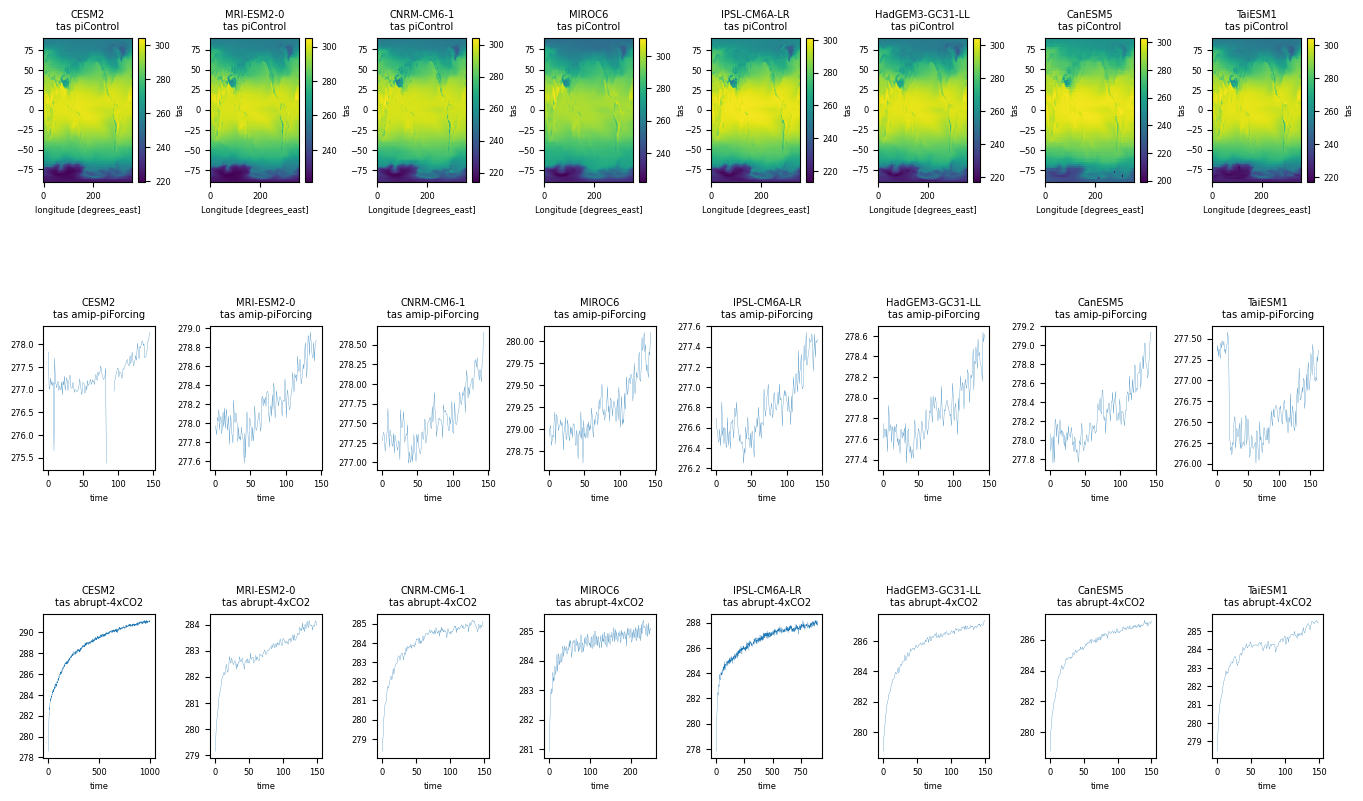

In [14]:
#### Do not change variables and dir_path
variables = [["toa-anom", "cre-anom", "tas-anom"],
             ["toa-annual", "cre-annual", "tas-annual"]]

var_name = ["toa", "cre", "tas"]
dir_path = [
    '/data/cristi/a/kchoo3/FluxesProcessing/pre-processed/anom', 
    '/data/cristi/a/kchoo3/FluxesProcessing/pre-processed/annual']

output_folder = '/data/cristi/a/kchoo3/FluxesProcessing/Analysis'
experiments = ["piControl", "amip-piForcing", "abrupt-4xCO2"]

# # # # # # # Code # # # # # # #
for n in range(len(variables[0])):
    plt.figure(figsize=[56, 20])
    fig, axs = plt.subplots(3, 8)
    for ex in range(len(experiments)):
        dsname = []
        '''
        Read the files. You may find them in this same directory the jupyter notebook file is in
        they are formated like this:
        [model1, variant_1, number_1, grid_1]
        [model2, variant_2, number_2, grid_2]
        ...
        '''
        dsname = ReadFile(f"{experiments[ex]}.txt")
        for mod in range(len(dsname)): #loop each model individually
            ds = []
            file_pattern = []
            ''' 
            Load each variables up and put them in stream of list. They look like this:
            [dir/tas_xx_xx_*.nc, dir/rsdt_xx_xx_*.nc, dir/rsut_xx_xx_*.nc, ...]
            '''
            if ex == "abrupt-4xCO2":
                file_path = NewFile(var=variables[0][n], model=dsname[mod][0], exp=experiments[ex], variant=dsname[mod][1])
                complete_path = (f"{dir_path[0]}/{file_path}")
            else:
                file_path = NewFile(var=variables[1][n], model=dsname[mod][0], exp=experiments[ex], variant=dsname[mod][1])
                complete_path = (f"{dir_path[1]}/{file_path}")
            file_pattern.append(complete_path)
            # open xarray datasets
            exist = True
            try:
                ds = Open_Files(file_pattern, exclude_files="None")
            except:
                print(f'could not find {file_pattern[0]}. skipping.')
                exist = False
            if exist == True:
                if experiments[ex] == "piControl":
                    ds[0][var_name[n]].mean(dim="time").plot(ax=axs[ex,mod])
                else:
                    resampled = ds[0].resample(time="YE").mean()
                    try:
                        resampled["time"] = resampled.indexes["time"].to_datetimeindex(unsafe=True)
                    except AttributeError:
                        pass
                    except ValueError:
                        pass
                    ds_annual=resampled.resample(time="1YE").mean(dim=['lat', 'lon'])
                    ds_annual[var_name[n]].plot(ax=axs[ex,mod], linewidth=0.2)
            # Figures styles
            i = 0
            j = 0
            for ax in axs.flat:
                ax.set_title(f"{dsname[i][0]}\n{var_name[n]} {experiments[j]}")
                ax.set_ylabel('')
                i += 1
                if i == 8:
                    i = 0
                    j += 1
            plt.savefig(f"{var_name[n]}_graph.png")
        plt.subplots_adjust(left=0, right=2, top=2.2, bottom=0.7, wspace=0.5, hspace=1)
        plt.rcParams['font.size'] = 6
        #plt.tight_layout()
        #plt.savefig(f"{var_name[n]}_graph.png")
        #plt.clf()

In [ ]:
#### Do not change variables and dir_path
variables = [["toa-anom", "cre-anom", "tas-anom"],
             ["toa-annual", "cre-annual", "tas-annual"]]

var_name = ["toa", "cre", "tas"]
dir_path = [
    '/data/cristi/a/kchoo3/FluxesProcessing/pre-processed/anom', 
    '/data/cristi/a/kchoo3/FluxesProcessing/pre-processed/annual']

output_folder = '/data/cristi/a/kchoo3/FluxesProcessing/Analysis'
experiments = ["piControl", "amip-piForcing", "abrupt-4xCO2"]

# # # # # # # Code # # # # # # #
for n in range(len(variables[0])):
    plt.figure(figsize=[56, 20])
    for ex in range(len(experiments)):
        dsname = []
        '''
        Read the files. You may find them in this same directory the jupyter notebook file is in
        they are formated like this:
        [model1, variant_1, number_1, grid_1]
        [model2, variant_2, number_2, grid_2]
        ...
        '''
        dsname = ReadFile(f"{experiments[ex]}.txt")
        for mod in range(len(dsname)): #loop each model individually
            ds = []
            file_pattern = []
            ''' 
            Load each variables up and put them in stream of list. They look like this:
            [dir/tas_xx_xx_*.nc, dir/rsdt_xx_xx_*.nc, dir/rsut_xx_xx_*.nc, ...]
            '''
            if ex == "abrupt-4xCO2":
                file_path = NewFile(var=variables[0][n], model=dsname[mod][0], exp=experiments[ex], variant=dsname[mod][1])
                complete_path = (f"{dir_path[0]}/{file_path}")
            else:
                file_path = NewFile(var=variables[1][n], model=dsname[mod][0], exp=experiments[ex], variant=dsname[mod][1])
                complete_path = (f"{dir_path[1]}/{file_path}")
            file_pattern.append(complete_path)
            # open xarray datasets
            exist = True
            try:
                ds = Open_Files(file_pattern, exclude_files="None")
            except:
                print(f'could not find {file_pattern[0]}. skipping.')
                exist = False
            if exist == True:
                if experiments[ex] == "piControl":
                    ds[0][var_name[n]].mean(dim="time").plot(ax=axs[ex,mod])
                else:
                    resampled = ds[0].resample(time="YE").mean()
                    try:
                        resampled["time"] = resampled.indexes["time"].to_datetimeindex(unsafe=True)
                    except AttributeError:
                        pass
                    except ValueError:
                        pass
                    ds_annual=resampled.resample(time="1YE").mean(dim=['lat', 'lon'])
                    ds_annual[var_name[n]].plot(ax=axs[ex,mod], linewidth=0.2)
            ax.set_title(f"{dsname[i][0]}\n{var_name[n]} {experiments[j]}")
            ax.set_ylabel('')
            plt.savefig(f"{var_name[n]}_graph.png")
        plt.subplots_adjust(left=0, right=2, top=2.2, bottom=0.7, wspace=0.5, hspace=1)
        plt.rcParams['font.size'] = 6
        #plt.tight_layout()
        #plt.savefig(f"{var_name[n]}_graph.png")
        #plt.clf()

## Ignore

In [7]:
#Testing
variables = ["toa-anom", "cre-anom", "tas-anom"]
var_name = ["toa", "cre", "tas"]
dir_path = '/data/cristi/a/kchoo3/FluxesProcessing/Processed'

output_folder = '/data/cristi/a/kchoo3/FluxesProcessing/Analysis'
experiments = ["piControl", "amip-piForcing", "abrupt-4xCO2", "amip"]

ds = []
ds.clear()
file_pattern = []
file_pattern.clear()
file_path = NewFile(var="toa-anom", model="CESM2", exp="amip", variant="r1i1p1f1")
complete_path = (f"{dir_path}/{file_path}")
file_pattern.append(complete_path)
ds = Open_Files(file_pattern, exclude_files="None")
ds[0]

<xarray.Dataset> Size: 96MB
Dimensions:  (lat: 192, lon: 288, time: 432)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 3kB 1979-01-15 12:00:00 ... 2014-12-15 12:00:00
Data variables:
    toa      (time, lat, lon) float32 96MB ...

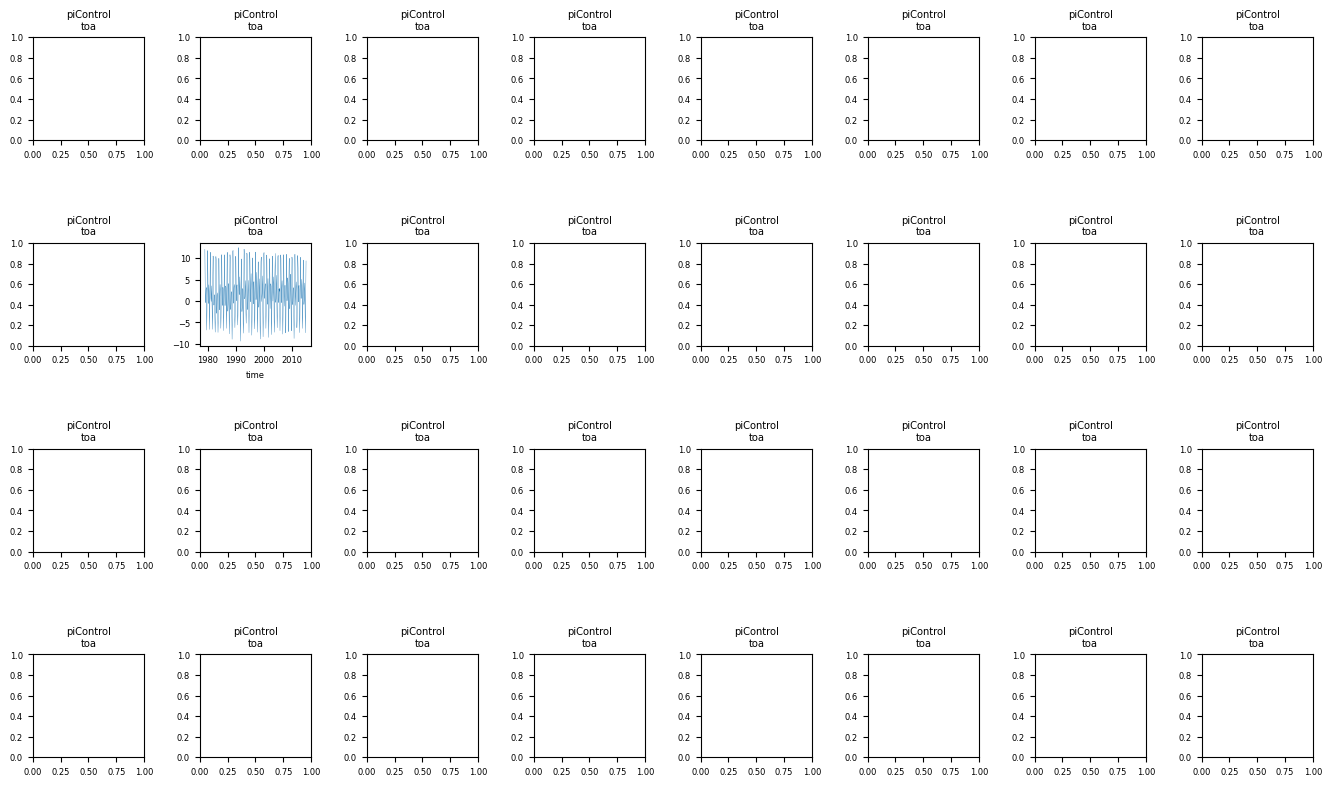

<Figure size 1000x2000 with 0 Axes>

In [10]:
fig, axs = plt.subplots(4, 8)
plt.subplots_adjust(left=0, right=2, top=2.2, bottom=0.7, wspace=0.5, hspace=1)
plt.figure(figsize=(10, 20))
plt.rcParams['font.size'] = 6
plt.tight_layout()
ds[0][var_name[0]].mean(dim=['lat', 'lon']).plot(ax=axs[1, 1], linewidth=0.25)
for ax in axs.flat:
    ax.set_title(f"{experiments[0]}\n{var_name[0]}")
    ax.set_ylabel('')